In [ ]:
# if necessary import google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# python script imports
import dataload_process

# package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RidgeCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score

import xgboost as xgb

In [ ]:
# Set a seed for reproducibility
np.random.seed(17)

# Load Data

In [ ]:
# Define the path to your CSV file
# dataset used: https://drive.google.com/file/d/1-07MOYij0cpKF1Ca3IjGKRBdaDCx9FjY/view?usp=drive_link
file_path = 'path/to/your/feed_forward_data.csv'


In [ ]:
# load dataframe
df = pd.read_csv(file_path)

In [ ]:
# split data into seperate X and y dataframes
x_df, y = dataload_process.split_data(df, 'price')


# Hyper-tune using Random Search Cross-Validation (CV)


In [ ]:
# Split the data into train 70% - test 30% sets
X_train, X_test, y_train, y_test = train_test_split(x_df, y, train_size=0.8, random_state=17)


In [ ]:
# Scale the features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest

In [ ]:
# Define the RF model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)


In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_cv = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Use negative mean squared error for regression
    cv=5,  # Number of cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

random_cv.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# Get the best RF model from the random search
best_rf_model = random_cv.best_estimator_

In [ ]:
# Make predictions
rf_pred1 = best_rf_model.predict(X_test_scaled)
# Calculate RMSE, MAE, and MSE
rf_mse1 = mean_squared_error(y_test, rf_pred1)
rf_rmse1 = np.sqrt(mean_squared_error(y_test, rf_pred1))
rf_mae1 = mean_absolute_error(y_test, rf_pred1)
rf_r21 = r2_score(y_test, rf_pred1)

In [ ]:
print('Random Forest R-squared:', rf_r21)
print('Random Forest MSE:', rf_mse1)
print('Random Forest RMSE:', rf_rmse1)
print('Random Forest MAE:', rf_mae1)

Random Forest R-squared: 0.8024134964627287
Random Forest MSE: 2239.8213905140856
Random Forest RMSE: 47.3267513200947
Random Forest MAE: 28.589591668331867


## XGBoost

In [ ]:
# Define the XGBRegressor model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


In [ ]:
# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': np.arange(100, 1000, 50),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 10),
    'min_child_weight': np.arange(1, 6),
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Create RandomizedSearchCV instance
random_cv = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform randomized cross-validation
random_cv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# Get the best XGBRegressor model from the random search
best_xgb_model = random_cv.best_estimator_


In [ ]:
# Make predictions on the test set
xgb_pred = best_xgb_model.predict(X_test_scaled)

# Calculate RMSE, MAE, and MSE
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

In [ ]:
print("XG Boost R-squared:", xgb_r2)
print('XG Boost Mean Squared Error (MSE):', xgb_mse)
print('XG Boost Root Mean Squared Error (RMSE):', xgb_rmse)
print('XG Boost Mean Absolute Error (MAE):', xgb_mae)

# Linear Regression

## Lasso

In [ ]:
# Define the Lasso model
lasso_model = Lasso()

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'alpha': np.logspace(-6, 6, 13)  # Range of alpha values for regularization
}

# Create RandomizedSearchCV instance for Lasso
random_cv_lasso = RandomizedSearchCV(
    estimator=lasso_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform randomized cross-validation for Lasso
random_cv_lasso.fit(X_train_scaled, y_train)

# Get the best Lasso model from the random search
best_lasso_model = random_cv_lasso.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e+09, tolerance: 4.598e+05
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Make predictions on the test set using Lasso
lasso_pred = best_lasso_model.predict(X_test_scaled)

# Calculate RMSE, MAE, and MSE
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
lasso_mae = mean_absolute_error(y_test, lasso_pred)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

In [ ]:
print("Lasso R-squared:", lasso_r2)
print("Lasso MSE:", lasso_mse)
print("Lasso RMSE:", lasso_rmse)
print("Lasso MAE:", lasso_mae)

Lasso R-squared: 0.48163590546779245
Lasso MSE: 5876.1249691768235
Lasso RMSE: 76.65588672226565
Lasso MAE: 56.727910107106744


## Ridge

In [ ]:
# Define the Ridge model
ridge_model = Ridge()

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'alpha': np.logspace(-6, 6, 13)
}

# Create RandomizedSearchCV instance
random_cv_ridge = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform randomized cross-validation
random_cv_ridge.fit(X_train_scaled, y_train)

# Get the best Ridge model from the random search
best_ridge_model = random_cv_ridge.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.27736e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [ ]:
# Make predictions on the test set
ridge_pred = best_ridge_model.predict(X_test_scaled)

# Calculate RMSE, MAE, and MSE
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

In [ ]:
print("Ridge R-squared:", ridge_r2)
print("Ridge MSE:", ridge_mse)
print("Ridge RMSE:", ridge_rmse)
print("Ridge MAE:", ridge_mae)

Ridge R-squared: 0.4854822413543618
Ridge MSE: 5832.523279589685
Ridge RMSE: 76.37095835191336
Ridge MAE: 56.46898600390509


## Elastic

In [ ]:
# Define the Elastic Net model
elastic_net_model = ElasticNet()

param_distributions = {
    'alpha': np.logspace(-6, 6, 13),   # Range of alpha values for regularization
    'l1_ratio': np.linspace(0, 1, 11)  # Range of l1_ratio values (0 to 1)
}


# Create RandomizedSearchCV instance for Elastic Net
random_cv_elastic_net = RandomizedSearchCV(
    estimator=elastic_net_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform randomized cross-validation for Elastic Net
random_cv_elastic_net.fit(X_train_scaled, y_train)

# Get the best Elastic Net model from the random search
best_elastic_net_model = random_cv_elastic_net.best_estimator_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e+09, tolerance: 4.598e+05
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Make predictions on the test set using Elastic Net
elastic_pred = best_elastic_net_model.predict(X_test_scaled)

# Calculate RMSE, MAE, and MSE
elastic_rmse = np.sqrt(mean_squared_error(y_test, elastic_pred))
elastic_mae = mean_absolute_error(y_test, elastic_pred)
elastic_mse = mean_squared_error(y_test, elastic_pred)
elastic_r2 = r2_score(y_test, elastic_pred)

In [ ]:
print("Elastic R-squared:", elastic_r2)
print('Elastic Mean Squared Error (MSE):', elastic_mse)
print('Elastic Root Mean Squared Error (RMSE):', elastic_rmse)
print('Elastic Mean Absolute Error (MAE):', elastic_mae)

Elastic R-squared: 0.48163507362421243
Elastic Mean Squared Error (MSE): 5876.134398874757
Elastic Root Mean Squared Error (RMSE): 76.6559482289193
Elastic Mean Absolute Error (MAE): 56.72854544209495


## SHAP
<br> SHAP (SHapley Additive exPlanations) is a unified measure of feature importance that allocates each feature an importance value for a particular prediction.

In [ ]:
!pip install shap
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.8 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
# modelname = name_of_best_model
# ex:
modelname = best_rf_model

In [ ]:
# Create the SHAP explainer for the trained model using KernelExplainer
explainer = shap.Explainer(modelname.predict, X_train_scaled)


In [ ]:
# Randomly sample 10k samples of the test data to calculate SHAP values
sample_size = min(10000, len(X_test_scaled))
random_indices = np.random.choice(X_test_scaled.shape[0], sample_size, replace=False)
X_test_sample = X_test_scaled[random_indices, :]

In [ ]:
# Calculate SHAP values for the sampled test data
shap_values = explainer.shap_values(X_test_sample)


Permutation explainer: 10001it [2:50:35,  1.02s/it]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


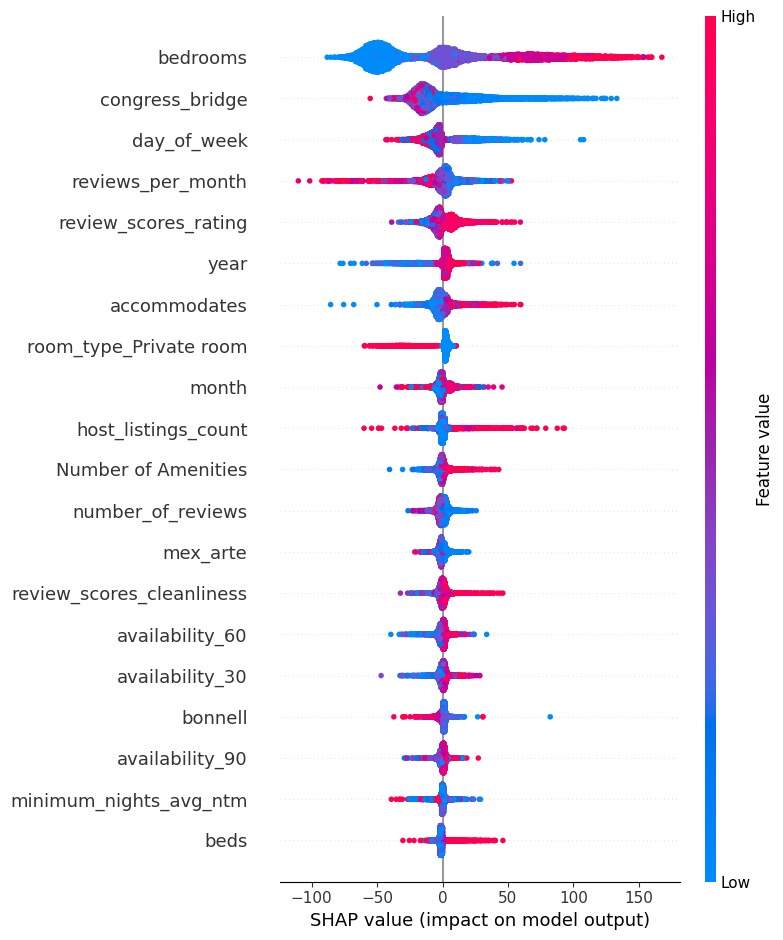

In [ ]:
# Plot summary
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test.columns)

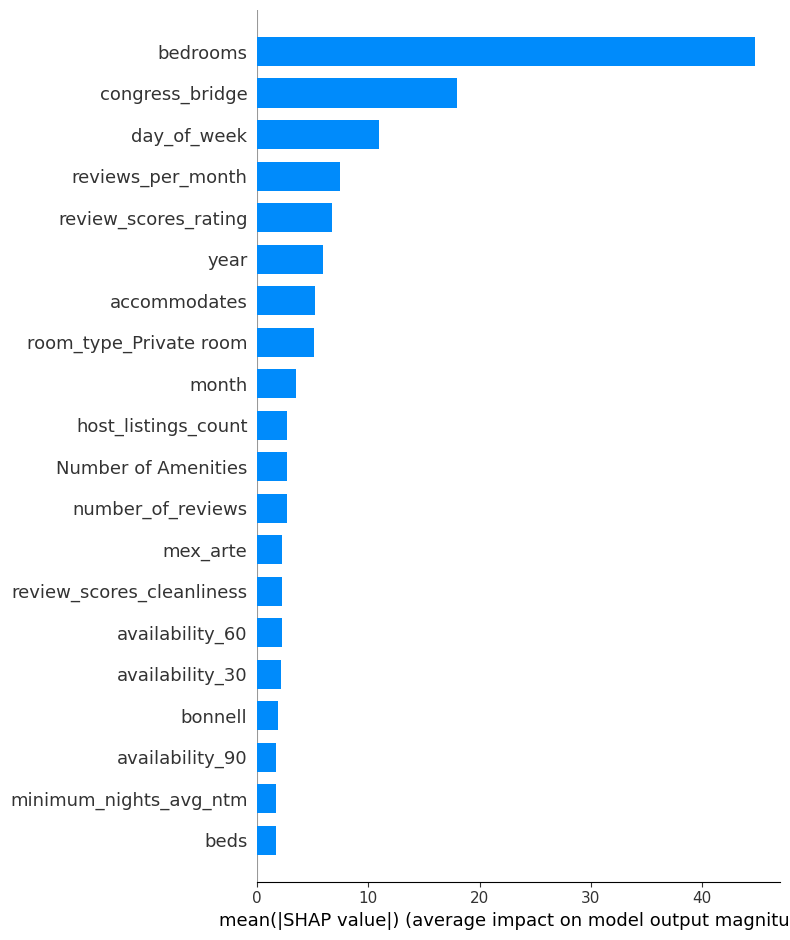

In [ ]:
# Bar Plot summary
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", feature_names=X_test.columns)


(optional)
Change column name (fix aesthetics of the plot)

In [ ]:
print(X_test.columns)

In [ ]:
# copy and paste columns to a new list with fixed names
col_names = ['Year',
 'Month',
 'Day Of Week',
 'Negative',
 'Compound',
 'Sentiment Score',
 'Host Is Superhost',
 'Host Listings Count',
 'Host Total Listings Count',
 'Neighbourhood Cleansed',
 'Latitude',
 'Longitude',
 'Accommodates',
 'Bedrooms',
 'Beds',
 'Minimum Nights',
 'Maximum Nights',
 'Minimum Minimum Nights',
 'Maximum Minimum Nights',
 'Minimum Maximum Nights',
 'Maximum Maximum Nights',
 'Minimum Nights Avg Ntm',
 'Maximum Nights Avg Ntm',
 'Availability 30',
 'Availability 60',
 'Availability 365',
 'Number Of Reviews',
 'Number Of Reviews Ltm',
 'Number Of Reviews L30d',
 'Review Scores Rating',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Value',
 'Instant Bookable',
 'Reviews Per Month',
 'Host Since',
 'Property Type Num',
 'Number Of Amenities',
 'Smoke Alarm',
 'Kitchen',
 'Essentials',
 'Free Parking On Premises',
 'Carbon Monoxide Alarm',
 'Hair Dryer',
 'Hangers',
 'Fire Extinguisher',
 'Iron',
 'Shampoo',
 'Dishes And Silverware',
 'Hot Water',
 'Refrigerator',
 'Heating',
 'Air Conditioning',
 'Cooking Basics',
 'Microwave',
 'Self Check-In',
 'Bed Linens',
 'First Aid Kit',
 'Washer',
 'Dedicated Workspace',
 'Dishwasher',
 'Tv',
 'Private Entrance',
 'Extra Pillows And Blankets',
 'Free Street Parking',
 'Coffee Maker',
 'Latitudesq',
 'Longitudesq',
 'T Cap',
 'Barton Springs',
 'Bullock',
 'Congress Bridge',
 'Zilker',
 'Ut Tower',
 'Dkr Stadium',
 'Mex Arte',
 'Mckinney',
 'Umlauf',
 'Bonnell',
 'Museum Weird',
 'Review Scores Location',
 'Room Type Hotel Room',
 'Room Type Private Room',
 'Room Type Shared Room']

In [ ]:
# Bar Plot summary with column names changed
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", feature_names=col_names)

In [ ]:
# Plot summary with column names changed
shap.summary_plot(shap_values, X_test_sample, feature_names=col_names)

### Interpreting summary plot for SHAP values
The summary plot of SHAP shows the overall impact of each feature on a particular prediction across a dataset. It visualizes the SHAP values for each feature for multiple instances in the dataset, typically represented as a horizontal bar chart. Each feature is assigned a color, and the plot displays the contribution of each feature to push the model's prediction away from a reference (usually the model's expected output or the average prediction).

The summary plot of SHAP can be interpreted as follows:

*  Features on the right side of the plot have a positive impact on pushing the prediction higher, while features on the left side have a negative impact on pushing the prediction lower.

*  The length of each bar or dot represents the magnitude of the SHAP value, indicating the strength of the feature's influence on the prediction.

*  The color of the bar represents the value of the feature for that particular instance. This coloring helps in understanding how the feature value affects the model's prediction.

*  For any given prediction, the sum of the SHAP values of all the features plus the model's expected output (average prediction) equals the actual prediction made by the model for that instance.